In [2]:
*(reference_path).glob('*'),

(PosixPath('XX01ZVNS2B/.DS_Store'),
 PosixPath('XX01ZVNS2B/crystallographic'),
 PosixPath('XX01ZVNS2B/aligned'),
 PosixPath('XX01ZVNS2B/metadata.csv'),
 PosixPath('XX01ZVNS2B/alternate_names.csv'),
 PosixPath('XX01ZVNS2B/hits_ids.csv'),
 PosixPath('XX01ZVNS2B/sites.csv'),
 PosixPath('XX01ZVNS2B/reference.pdb'))

In [1]:
from pathlib import Path
target_name = 'XX01ZVNS2B'
reference_path = Path(target_name)

In [3]:
import pandas as pd

meta = pd.read_csv(reference_path / 'metadata.csv') # site_name smiles

In [4]:
import pyrosetta
import pyrosetta_help as ph
import logging

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)


extra_options = ph.make_option_string(no_optH=False,
                                      ex1=None,
                                      ex2=None,
                                      #mute='all',
                                      ignore_unrecognized_res=True,
                                      load_PDB_components=False,
                                      ignore_waters=False)
pyrosetta.init(extra_options=extra_options)

/Users/user/.conda/envs/py310/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.m1 2023.16+release.942c01d5066fd96860b7d268702b832fe906a739 2023-04-12T15:05:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit_to_params import Params
from typing import List, Dict, Union, Optional, Any, Sequence

logger = logging.getLogger()
if logger.handlers:
    logger.handlers[0].setLevel(logging.ERROR)
    
    
import os
import importlib.util
from types import ModuleType

def import_path(module_path, module_name='custom_module') -> ModuleType:
    """
    A more elegant way that the adding to PATH via sys IMO.
    """
    spec = importlib.util.spec_from_file_location(module_name, module_path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod


from plip.basic import config

config.NOHYDRO = True
# config.NOPDBCANMAP = False # no idea.
# config.KEEPMOD these are mod residues...


module_path = (Path.home() / 'Coding' / 'Fragment-hit-follow-chemistry' / 'followup' / 'plip.py')
SerialPLIPper = import_path(module_path).SerialPLIPper
    
def load_pose(holo_path: Union[str, Path], smiles: str):
    #pose = ph.parameterized_pose_from_file(holo_path, wanted_ligands={'LIG': smiles}, proximityBonding=True)
    params = Params.from_smiles_w_pdbfile(str(holo_path), smiles=smiles, name='LIG', proximityBonding=True)
    pose = pyrosetta.Pose()
    params.add_residuetype(pose, True)
    pyrosetta.pose_from_file(pose, str(holo_path))
    return pose, params

def lig_details(pose: pyrosetta.Pose, resn='LIG'):
    # this is a weird way of doing but 
    # the Selector approach is glitchy nn-std type set names
    for i, lig in enumerate(pose.residues):
        if lig.name3() == resn:
            lig_num = i+1
            break
    else:
        raise ValueError(f'{resn} absent — unrecognised?')
    #assert lig.name3() == 'LIG', 'Not LIG
    atom_names: List[str] = [lig.atom_name(i+1) for i in range(lig.natoms())]
    lig_resi=pose.pdb_info().number(lig_num)
    lig_chain=pose.pdb_info().chain(lig_num)
    return atom_names, lig_resi, lig_chain

In [58]:
#analysis = {}

for i, row in meta.iterrows():
    if row.crystal_name in analysis:
        continue
    # f'{target_name}-{hit_name}'
    folder = reference_path / 'aligned' / row.crystal_name
    holo_path = folder / f'{row.crystal_name}_bound.pdb'
    try:
        pose, params = load_pose(holo_path, row.smiles)
        pdb_block: str = ph.get_pdbstr(pose)
    except Exception as error:
        print(error.__class__.__name__, error, row.crystal_name)
        continue
    # store
    pose.dump_pdb(str(folder / f'{row.crystal_name}_protonated.pdb'))
    params.dump(str(folder / f'{row.crystal_name}.params'))
    # details
    atom_names, lig_resi, lig_chain = lig_details(pose)
    plipper = SerialPLIPper(ph.get_pdbstr(pose),
                        resn='LIG',
                        resi=lig_resi,
                        chain=lig_chain)
    details = summarize_interactions(plipper)
    analysis[row.crystal_name] = dict(resn='LIG',
                                        resi=lig_resi,
                                        chain=lig_chain,
                                        interactions=details)

AssertionError LIG is split in 2 XX01ZVNS2B-x0553_0B
AssertionError LIG is split in 2 XX01ZVNS2B-x0589_0B
AssertionError LIG is split in 2 XX01ZVNS2B-x0605_0B
KeyError 'LIG' XX01ZVNS2B-x0917_0B
KeyError 'LIG' XX01ZVNS2B-x0917_1B


In [61]:
import json

with open('hit_interactions.json', 'w') as w:
    json.dump(analysis, w)

In [65]:
pd.DataFrame([{**dict(crystal=k, resn=d['resn'], chain=d['chain'], intxn_N=di),
               **dd} for k, d in analysis.items() for di, dd in enumerate(d['interactions'])])\
  .to_csv('hit_interactions.csv')

In [ ]:
print('\n'.join([l for l in holo_path.read_text().split('\n') if 'LIG' in l or 'CON' in l]))

In [2]:
'XX01ZVNS2B_X0404'

import pandas as pd

df = pd.read_csv('hit_interactions.csv')

In [7]:
df.loc[df.crystal.str.contains('XX01ZVNS2B-x0404')]

,Unnamed: 0,crystal,resn,chain,intxn_N,type,protein_resn,protein_resi,protein_chain,atom_names,babel_atom_types,distance
44,44,XX01ZVNS2B-x0404_0B,LIG,B,0,hbond_donor,SER,81,A,[' N1 '],['N3'],2.930481
45,45,XX01ZVNS2B-x0404_0B,LIG,B,1,hydroph_interaction,HIS,51,B,[' C5 '],['C2'],3.940756


In [ ]:
row = meta.loc[meta.crystal_name == 'XX01ZVNS2B-x0404_0B'].iloc[0]


folder = reference_path / 'aligned' / row.crystal_name
holo_path = folder / f'{row.crystal_name}_bound.pdb'
try:
    pose, params = load_pose(holo_path, row.smiles)
    pdb_block: str = ph.get_pdbstr(pose)
except Exception as error:
    print(error.__class__.__name__, error, row.crystal_name)
# store
pose.dump_pdb(str(folder / f'{row.crystal_name}_protonated.pdb'))
params.dump(str(folder / f'{row.crystal_name}.params'))
# details
atom_names, lig_resi, lig_chain = lig_details(pose)
plipper = SerialPLIPper(ph.get_pdbstr(pose),
                    resn='LIG',
                    resi=lig_resi,
                    chain=lig_chain)
details = plipper.summarize_interactions(atom_names)

In [9]:
from plip.structure.preparation import PDBComplex, PLInteraction

holo = PDBComplex()
holo.load_pdb(str(folder / f'{row.crystal_name}_protonated.pdb'))

2023-07-21 11:53:12,224 [WARNING] [preparation.py:1401] plip.structure.preparation: no polar hydrogens will be assigned (make sure your structure contains hydrogens)


In [10]:
holo.analyze()

In [16]:
with open(Path.home() / 'Coding/Zika-NS2B/tmp2.pdb', 'w') as w:
    w.write(holo.corrected_pdb)

In [19]:
from plip.basic import config

config.AROMATIC_PLANARITY,\
config.PISTACK_ANG_DEV,\
config.PISTACK_DIST_MAX,\
config.PISTACK_OFFSET_MAX

(5.0, 30, 5.5, 2.0)

In [ ]:
1	51B	HIS	3.61	8.68	1.09	P	1754, 1755, 1756, 1757, 1758, 1759

In [30]:
plipper = SerialPLIPper('\n'.join([line for line in ph.get_pdbstr(pose).split('\n') if not any([k in line for k in ('  H', 'CONECT')])]),
                    resn='LIG',
                    resi=lig_resi,
                    chain=lig_chain)
plipper.summarize_interactions(atom_names)

[{'type': 'hbond_donor',
  'protein_resn': 'ASP',
  'protein_resi': 83,
  'protein_chain': 'A',
  'atom_names': [' N1 '],
  'babel_atom_types': ['N3'],
  'distance': 2.861189437978547},
 {'type': 'pication_ring',
  'protein_resn': 'HIS',
  'protein_resi': 51,
  'protein_chain': 'B',
  'atom_names': [' C1 ', ' C6 ', ' C2 ', ' C5 ', ' C3 ', ' C4 '],
  'babel_atom_types': ['Car', 'Car', 'Car', 'Car', 'Car', 'Car'],
  'distance': 3.7350021158702917}]

In [90]:
config.NOHYDRO = True # as don't add

holo = PDBComplex()
block = ph.get_pdbstr(pose)
# remove Hs and CONECT
#block = '\n'.join([line for line in block.split('\n') if not any([k in line for k in ('  H', 'CONECT')])])
#block = '\n'.join([line for line in block.split('\n') if not any([k in line for k in ('  H',)])])

holo.load_pdb(block, as_string=True)

[a.type for a in holo.ligands[0].mol.atoms]

2023-07-21 13:43:11,676 [WARNING] [preparation.py:1401] plip.structure.preparation: no polar hydrogens will be assigned (make sure your structure contains hydrogens)


['C3',
 'So2',
 'O2',
 'O2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'Npl',
 'C3',
 'C3',
 'C3',
 'C3',
 'N3']

In [92]:
correct = ['C3',
 'So2',
 'O2',
 'O2',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Npl',
 'C3',
 'C3',
 'C3',
 'C3',
 'N3']

for c, a in zip(correct, holo.ligands[0].mol.atoms):
    a.OBAtom.SetType(c)
    
[a.type for a in holo.ligands[0].mol.atoms]

['C3',
 'So2',
 'O2',
 'O2',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Npl',
 'C3',
 'C3',
 'C3',
 'C3',
 'N3']

In [84]:
holo.analyze()

In [19]:
from openbabel import pybel
from plip.basic import config
from plip.structure.preparation import PDBComplex

config.NOHYDRO = True # as don't add. Default is False

holo = PDBComplex()
block = open(str( Path.home()) + '/Coding/Zika-NS2B/XX01ZVNS2B/aligned/XX01ZVNS2B-x0404_0B/XX01ZVNS2B-x0404_0B_protonated.pdb').read()
# remove Hs and CONECT
#block = '\n'.join([line for line in block.split('\n') if not any([k in line for k in ('  H', 'CONECT')])])
#block = '\n'.join([line for line in block.split('\n') if not any([k in line for k in ('  H',)])])

holo.load_pdb(block, as_string=True)

[a.type for a in holo.ligands[0].mol.atoms]

2023-07-21 14:28:20,163 [WARNING] [preparation.py:1401] plip.structure.preparation: no polar hydrogens will be assigned (make sure your structure contains hydrogens)


Monkey!


['C3',
 'So2',
 'O2',
 'O2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'Npl',
 'C3',
 'C3',
 'C3',
 'C3',
 'N3']

In [93]:
config.NOHYDRO = False
plipper = SerialPLIPper(ph.get_pdbstr(pose),
                    resn='LIG',
                    resi=lig_resi,
                    chain=lig_chain)
plipper.summarize_interactions(atom_names)

[{'type': 'hbond_donor',
  'protein_resn': 'SER',
  'protein_resi': 81,
  'protein_chain': 'A',
  'atom_names': [' N1 '],
  'babel_atom_types': ['N3'],
  'distance': 2.930480506674631},
 {'type': 'hydroph_interaction',
  'protein_resn': 'HIS',
  'protein_resi': 51,
  'protein_chain': 'B',
  'atom_names': [' C5 '],
  'babel_atom_types': ['C2'],
  'distance': 3.9407555113201336}]

In [89]:
holo.interaction_sets['LIG:B:301'].all_itypes[1]

hydroph_interaction(bsatom=<openbabel.pybel.Atom object at 0x287280be0>, bsatom_orig_idx=1588, ligatom=<openbabel.pybel.Atom object at 0x2873c1600>, ligatom_orig_idx=3397, distance=3.9407555113201336, restype='HIS', resnr=51, reschain='B', restype_l='LIG', resnr_l=301, reschain_l='B')

In [6]:
from openbabel import pybel
from pathlib import Path

apo = pybel.readfile(
    'pdb',
    str( Path.home()) + '/Coding/Zika-NS2B/XX01ZVNS2B/aligned/XX01ZVNS2B-x0404_0B/XX01ZVNS2B-x0404_0B_apo.pdb',
opt={"s": None}           
).__next__()

mol = pybel.readfile(
    'mol',
    str( Path.home()) + '/Coding/Zika-NS2B/XX01ZVNS2B/aligned/XX01ZVNS2B-x0404_0B/XX01ZVNS2B-x0404_0B.mol',          
).__next__()

In [3]:
opt={"s": None}  

s	Output single bonds only
b	Disable bonding entirely
c	Ignore CONECT records

openbabel.pybel.Molecule

In [1]:
from openbabel import pybel
from pathlib import Path

apo = pybel.readfile(
    'pdb',
    str( Path.home()) + '/Coding/Zika-NS2B/XX01ZVNS2B/aligned/XX01ZVNS2B-x0404_0B/XX01ZVNS2B-x0404_0B_protonated.pdb',
#opt={"s": None}           
).__next__()

In [ ]:
apo.OBMol.

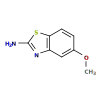

In [2]:
mol.clone

In [70]:
import plip.basic.supplemental as supp
from openbabel import pybel
import logging
logger = supp.logger
import sys

def readmol(path, as_string=False):
    """Reads the given molecule file and returns the corresponding Pybel molecule as well as the input file type.
    In contrast to the standard Pybel implementation, the file is closed properly."""
    print('Monkey!')
    supported_formats = ['pdb']
    # Fix for Windows-generated files: Remove carriage return characters
    if "\r" in path and as_string:
        path = path.replace('\r', '')

    for sformat in supported_formats:
        obc = pybel.ob.OBConversion()
        obc.SetInFormat(sformat)
        logger.debug(f'detected {sformat} as format, trying to read file with OpenBabel')

        # Read molecules with single bond information
        if as_string:
            try:
                mymol = pybel.readstring(sformat, path)
            except IOError:
                logger.error('no valid file format provided')
                sys.exit(1)
        else:
            read_file = pybel.readfile(format=sformat, filename=path,
                                       #opt={"s": None}
                                      )
            try:
                mymol = next(read_file)
            except StopIteration:
                logger.error('file contains no valid molecules')
                sys.exit(1)

        logger.debug('molecule successfully read')

        # Assign multiple bonds
        #mymol.OBMol.PerceiveBondOrders()
        return mymol, sformat
    
supp.readmol = readmol

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import pybel
from plip.basic import config
from plip.structure.preparation import PDBComplex


config.NOHYDRO = True
mol = AllChem.AddHs(Chem.MolFromSmiles('c1ccccc1'))
AllChem.EmbedMolecule(mol)

block = Chem.MolToPDBBlock(mol)  # rubbish CONECT is flavor=8
pb_mol = pybel.readstring('pdb', block, {'s': None})
print([a.type for a in pb_mol.atoms])
pb_mol.OBMol.PerceiveBondOrders()
print([a.type for a in pb_mol.atoms])
p = PDBComplex()
p.load_pdb(block, as_string=True)
[a.type for a in p.ligands[0].mol.atoms]

2023-07-21 15:34:54,005 [WARNING] [preparation.py:1401] plip.structure.preparation: no polar hydrogens will be assigned (make sure your structure contains hydrogens)


['Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'H', 'H', 'H', 'H', 'H', 'H']
['Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'H', 'H', 'H', 'H', 'H', 'H']


['C2', 'C2', 'C2', 'C2', 'C2', 'C2']

In [ ]:
flavor 0
CONECT    1    2    2    6
CONECT    2    3
CONECT    3    4    4
CONECT    4    5
CONECT    5    6    6
flavor 8
CONECT    1    2    6
CONECT    2    3
CONECT    3    4
CONECT    4    5
CONECT    5    6

In [78]:
block = '''HETATM    1  C1  UNL     1       0.116  -1.105   0.817  1.00  0.00           C  
HETATM    2  C2  UNL     1       0.246   0.158   1.345  1.00  0.00           C  
HETATM    3  C3  UNL     1       0.378   1.285   0.545  1.00  0.00           C  
HETATM    4  C4  UNL     1       0.376   1.106  -0.824  1.00  0.00           C  
HETATM    5  C5  UNL     1       0.245  -0.167  -1.334  1.00  0.00           C  
HETATM    6  C6  UNL     1       0.115  -1.277  -0.550  1.00  0.00           C  
CONECT    1    2    2    6
CONECT    2    3
CONECT    3    4    4
CONECT    4    5
CONECT    5    6    6
END
'''

pb_mol = pybel.readstring('pdb', block, {'s': None})
pb_mol.OBMol.PerceiveBondOrders()
[a.type for a in pb_mol.atoms]

['Car', 'Car', 'Car', 'Car', 'Car', 'Car']

In [71]:
config.NOHYDRO = True # as don't add

holo = PDBComplex()
# remove Hs and CONECT
#block = '\n'.join([line for line in block.split('\n') if not any([k in line for k in ('  H', 'CONECT')])])
#block = '\n'.join([line for line in block.split('\n') if not any([k in line for k in ('  H',)])])

holo.load_pdb(block, as_string=True)

[a.type for a in holo.ligands[0].mol.atoms]

2023-07-21 14:47:06,869 [WARNING] [preparation.py:1401] plip.structure.preparation: no polar hydrogens will be assigned (make sure your structure contains hydrogens)


Monkey!


['C3',
 'So2',
 'O2',
 'O2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'Npl',
 'C3',
 'C3',
 'C3',
 'C3',
 'N3']

In [80]:
help(Chem.MolToPDBBlock)

Help on built-in function MolToPDBBlock in module rdkit.Chem.rdmolfiles:

MolToPDBBlock(...)
    MolToPDBBlock( (Mol)mol [, (int)confId=-1 [, (int)flavor=0]]) -> str :
        Returns a PDB block for a molecule
          ARGUMENTS:
        
            - mol: the molecule
            - confId: (optional) selects which conformation to output (-1 = default)
            - flavor: (optional) 
                    - flavor & 1 : Write MODEL/ENDMDL lines around each record 
                    - flavor & 2 : Don't write any CONECT records 
                    - flavor & 4 : Write CONECT records in both directions 
                    - flavor & 8 : Don't use multiple CONECTs to encode bond order 
                    - flavor & 16 : Write MASTER record 
                    - flavor & 32 : Write TER record 
        
          RETURNS:
        
            a string
        
        
    
        C++ signature :
            std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::alloc